(remote-function)=
# Ray Remote Functions

A remote function, also known as a task, is a function that can be scaled on a Ray cluster. Remote functions are stateless, meaning their execution only depends on the input and output of the function and does not rely on any intermediate variables.

In the following examples, we will demonstrate how to horizontally scale Python functions to a Ray cluster:

* Generating the Fibonacci Sequence

* Computing $\pi$ with the Monte Carlo Method

* Distributed Image Processing

In [1]:
%config InlineBackend.figure_format = 'svg'
import logging
import math
import os
import random
import time
from pathlib import Path
from typing import List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision
from torchvision import transforms as T

import ray

## Start a Ray Cluster

Before using the distributed features of Ray, you need to start a Ray cluster. There are several ways to start a Ray cluster, and one of them is by using the [`ray.init()`](https://docs.ray.io/en/latest/ray-core/api/doc/ray.init.html) function to start a single-node Ray cluster for demonstration purposes.

In [2]:
if ray.is_initialized:
    ray.shutdown()
ray.init(logging_level=logging.ERROR)

RayContext(dashboard_url='', python_version='3.11.7', ray_version='2.9.0', ray_commit='9be5a16e3ccad0710bba08d0f75e9ff774ae6880', protocol_version=None)

## Example 1: Fibonacci Sequence

Next, we demonstrate how to use Ray to distribute Python functions by using the Fibonacci sequence example.

The $n^{th}$ term $F_n$ of the Fibonacci sequence can be calculated from the two preceding terms $F_{n-1}$ and $F_{n-2}$. It is defined by the formal mathematical formula:

$$
F_n = F_{n-1} + F_{n-2}
$$

where $F_0 = 0$ and $F_1 = 1$.

Below, we define a Fibonacci function using native Python.

In [3]:
def generate_fibonacci(sequence_size):
    fibonacci = []
    for i in range(0, sequence_size):
        if i < 2:
            fibonacci.append(i)
            continue
        fibonacci.append(fibonacci[i-1] + fibonacci[i-2])
    return len(fibonacci)

If we intend to scale this Python function using Ray, just add the `@ray.remote` decorator.

In [4]:
# add @ray.remote decorator
@ray.remote
def generate_fibonacci_distributed(sequence_size):
    return generate_fibonacci(sequence_size)

As users of Ray, we do not need to concern how tasks are distributed and scheduled within the cluster. Nor do we need to delve into the specifics of which computational nodes the tasks are dispatched to. Ray effectively abstracts and handles the intricacies of distributed execution, managing the underlying distributed and scheduling tasks on our behalf.

Let's compare the efficiency and time consumption of sequential execution with distributed execution. [`os.cpu_count()`](https://docs.python.org/3/library/os.html#os.cpu_count) provides the current number of CPU cores. The serial execution code employs a `for` loop, iteratively calling a function to generate Fibonacci sequences.

In [5]:
# serial execution
def run_local(sequence_size):
    results = [generate_fibonacci(sequence_size) for _ in range(os.cpu_count())]
    return results

Using Ray to execute in parallel across multiple CPU cores.

In [6]:
# parallel execution
def run_remote(sequence_size):
    results = ray.get([generate_fibonacci_distributed.remote(sequence_size) for _ in range(os.cpu_count())])
    return results

In [7]:
SEQUENCE_SIZE = 200000

start = time.time()
run_local(SEQUENCE_SIZE)
end = time.time()
elapsed_fib_serial = end - start
print(f"Serial :: fibonacci sequence {SEQUENCE_SIZE} elapsed: {elapsed_fib_serial:.2f} sec")

start = time.time()
run_remote(SEQUENCE_SIZE)
end = time.time()
elapsed_fib_dist = end - start
print(f"Distributed :: fibonacci sequence {SEQUENCE_SIZE} elapsed: {elapsed_fib_dist:.2f} sec")

Serial :: fibonacci sequence 200000 elapsed: 7.04 sec
Distributed :: fibonacci sequence 200000 elapsed: 8.42 sec


In this example, the workload may not be so complex. You can try increasing the value of `SEQUENCE_SIZE` for a performance comparison with larger workloads.

## Differences Between Native Python Functions and Ray

It's essential to note the distinctions between using Ray and native Python functions, primarily in:

* Invocation Method

For native Python functions, the call is made using `func_name()`. When using Ray, the function definition requires the addition of the `@ray.remote` decorator, and the invocation takes the form of [`func_name.remote()`](https://docs.ray.io/en/latest/ray-core/api/doc/ray.remote.html).

* Return Values

Invoking a native Python function, such as `func_name()`, yields the function's return value. In Ray, `func_name.remote()` returns an object of type `ray.ObjectRef`. `ray.ObjectRef` is not a concrete value but a Future, representing a computation that is yet to be completed. To obtain the actual return value of the call, [`ray.get()`](https://docs.ray.io/en/latest/ray-core/api/doc/ray.get.html) is used.

* Execution Mode

The invocation of a native Python function, like `func_name()`, is synchronous, meaning it waits for the result before proceeding with further computations. A Ray function, `func_name.remote()`, is asynchronous. The caller does not need to wait for the actual execution of the function; Ray immediately returns a `ray.ObjectRef`, and the function's computation takes place in the background on specific computing nodes. `ray.get(ObjectRef)` waits for the background computation to complete and returns the result to the caller. `ray.get(ObjectRef)` is a blocking call.

## Example 2: Monte Carlo Estimation of $\pi$

Next, we use the Monte Carlo method to estimate $\pi$. As illustrated in the {ref}`square-circle`, we randomly scatter points within a $2 \times 2$ square, which contains a circle with a radius of 1. The points are distributed with a certain probability of landing inside the circle. Assuming we already know the probability of a point falling inside the circle is $\frac{\pi}{4}$, we can deduce the value of $\pi$ based on the probability of randomly scattered points. According to probability theory, as the number of points scattered increases, the probability converges to the true value.

```{figure} ../img/ch-ray-core/square-circle-pi.svg
---
width: 500px
name: square-circle
---
Randomly scatter points into the square, and points have a certain probability of landing inside the circle.
```

In [8]:
NUM_SAMPLING_TASKS = os.cpu_count()
NUM_SAMPLES_PER_TASK = 10_000_000
TOTAL_NUM_SAMPLES = NUM_SAMPLING_TASKS * NUM_SAMPLES_PER_TASK

We define a native Python function to calculate the probability of points falling inside the circle. We perform a total of `num_samples` random samples, or in other words, we scatter `num_samples` points. Each point is generated by obtaining random values for the coordinates `x` and `y` within the $[-1, 1]$ interval. If the point falls within the circle, its distance from the center (origin at the coordinate axes) is less than or equal to 1. The [math.hypot](https://docs.python.org/3/library/math.html#math.hypot) function from the math library can be used to calculate the distance.

In [9]:
def sampling_task(num_samples: int, task_id: int, verbose=True) -> int:
    num_inside = 0
    for i in range(num_samples):
        x, y = random.uniform(-1, 1), random.uniform(-1, 1)
        # in the circle
        if math.hypot(x, y) <= 1:
            num_inside += 1
    if verbose:
        print(f"Task id: {task_id} | Samples in the circle: {num_inside}")
    return num_inside

We define a serial executed native Python function, calling it a total of `NUM_SAMPLING_TASKS` times sequentially.

In [10]:
def run_serial(sample_size) -> List[int]:
    results = [sampling_task(sample_size, i+1) for i in range(NUM_SAMPLING_TASKS)]
    return results

Next, we define a remote function by simply adding the `@ray.remote` decorator. It is essential to remember that remote functions are executed asynchronously. When calling a remote function, it immediately returns a future `ObjectRef`, and the actual computation result can be obtained using `ray.get()`. `ray.get()` blocks to wait for the computation to complete and returns the actual result.

In [11]:
@ray.remote
def sample_task_distribute(sample_size, i) -> object:
    return sampling_task(sample_size, i)

def run_disributed(sample_size) -> List[int]:
    results = ray.get([
            sample_task_distribute.remote(sample_size, i+1) for i in range(NUM_SAMPLING_TASKS)
        ])
    return results

Calculate $\pi$:

In [12]:
def calculate_pi(results: List[int]) -> float:
    total_num_inside = sum(results)
    pi = (total_num_inside * 4) / TOTAL_NUM_SAMPLES
    return pi

Time consumed between serial and Ray distributed execution:

In [13]:
start = time.time()
results = run_serial(NUM_SAMPLES_PER_TASK)
pi = calculate_pi(results)
end = time.time()
elapsed_pi_serial = end - start
print(f"Serial :: random samples: {NUM_SAMPLES_PER_TASK}, estimated value of π is: {pi:5f}, elapsed: {elapsed_pi_serial:.2f} sec")

start = time.time()
results = run_disributed(NUM_SAMPLES_PER_TASK)
pi = calculate_pi(results)
end = time.time()
elapsed_pi_dist = end - start
print(f"Distributed :: random samples: {NUM_SAMPLES_PER_TASK}, estimated value of π is: {pi:5f}, elapsed: {elapsed_pi_dist:.2f} sec")

Task id: 1 | Samples in the circle: 7855196
Task id: 2 | Samples in the circle: 7855087
Task id: 3 | Samples in the circle: 7854935
Task id: 4 | Samples in the circle: 7853540
Task id: 5 | Samples in the circle: 7854832
Task id: 6 | Samples in the circle: 7854791
Task id: 7 | Samples in the circle: 7855140
Task id: 8 | Samples in the circle: 7855565
Task id: 9 | Samples in the circle: 7854580
Task id: 10 | Samples in the circle: 7853349
Task id: 11 | Samples in the circle: 7854326
Task id: 12 | Samples in the circle: 7856231
Serial :: random samples: 10000000, estimated value of π is: 3.141919, elapsed: 24.70 sec
(sample_task_distribute pid=80658) Task id: 9 | Samples in the circle: 7852849
Distributed :: random samples: 10000000, estimated value of π is: 3.141651, elapsed: 3.51 sec


(sample_task_distribute pid=80649) Task id: 7 | Samples in the circle: 7853679


## Example 3: Distributed Image Processing

Next, let's simulate a more computationally intensive distributed task: preprocessing images. The images are high-resolution images, approximately 4MB each. Image data preprocessing is a common task in artificial intelligence.

The tasks involved include:

* Utilizing PyTorch's [`torchvision`](https://pytorch.org/vision/stable/index.html#module-torchvision) library tools to randomly generate a dataset of images.
* Loading images using the PIL library.
* Applying preprocessing and data augmentation from the `torchvision` library, transforming the processed images into `Tensor` format.

We will generate a random dataset of images with dimensions $3000 \times 3000$ and save them in jpg format.

In [14]:
NUM_IMAGES = 50
# Put images into the folder
DATA_DIR = Path(os.getcwd() + "/../data/fake-images")

if not DATA_DIR.exists():
    # create the folder if not exists
    DATA_DIR.mkdir(parents=True)
    print(f'Creating directory: {DATA_DIR}.')

    # dataset is List, with each (Image, Label)
    dataset = torchvision.datasets.FakeData(size=NUM_IMAGES, image_size=(3, 3000, 3000))
    for i in range(NUM_IMAGES):
        dest = DATA_DIR / f"{str(i)}.jpg"
        dataset[i][0].save(dest, quality=60)

计算密集型函数 `transform_image`，模拟了深度学习中经常使用的图片数据预处理和数据增强操作。

In [15]:
def transform_image(img: object):
    # torchvision provides data preprocessing operations
    img = T.RandomHorizontalFlip()(img)
    img = T.RandomCrop(size=[224, 224], padding=4)(img)
    img = T.ToTensor()(img)
    img = T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(img)

    return img

Define serial and parallel functions:

In [16]:
def augment_image_serial(image: object) -> List[object]:
    image = Image.open(image)
    return transform_image(image)

@ray.remote
def augment_image_distributed(image: object) -> List[object]:
    image = Image.open(image)
    return transform_image(image)

def run_serially(dataset) -> List[object]:
    transform_results = [augment_image_serial(image) for image in dataset]
    return transform_results

def run_distributed(dataset: List) ->  List[object]:
    return ray.get([augment_image_distributed.remote(image) for image in dataset])

Compare time consumed:

In [17]:
image_path_list = list(DATA_DIR.glob("*.jpg"))

# serial
print(f"Running {len(image_path_list)} images serially....")
start = time.time()
serial_results = run_serially(image_path_list)
end = time.time()
elapsed_img_serial = end - start
print(f"Serial :: transformations of {len(image_path_list)} images, {elapsed_img_serial:.2f} sec")

# parallel
print(f"Running {len(image_path_list)} images distributed....")
start = time.time()
distributed_results = run_distributed(image_path_list)
end = time.time()
elapsed_img_dist = end - start
print(f"Distributed :: transformations of {len(image_path_list)} images, {elapsed_img_dist:.2f} sec")

Running 50 images serially....
Serial :: transformations of 50 images, 3.78 sec
Running 50 images distributed....
Distributed :: transformations of 50 images, 1.79 sec


After showing the three examples, let's compare the efficiency of Ray's distributed execution. Each example has its own characteristics: the Fibonacci sequence calculation is relatively simple, primarily utilizing native Python functionalities (lists, addition); the Monte Carlo estimation of $\pi$ task involves calls to two Python standard libraries, `random` and `math` ; the image processing task calls more complex third-party libraries, `torch`, `torchvision`, and `pillow`, with `pillow` and `torch` having more intricate underlying implementations.

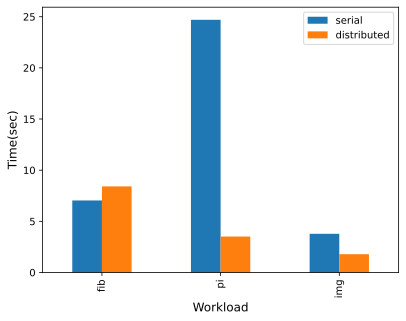

In [18]:
data = {'workload': ["fib", "pi", "img"],
        'serial' : [elapsed_fib_serial, elapsed_pi_serial, elapsed_img_serial],
        'distributed': [elapsed_fib_dist, elapsed_pi_dist, elapsed_img_dist]}

df = pd.DataFrame(data)
df.plot(x="workload", y=["serial", "distributed"], kind="bar")
plt.ylabel('Time(sec)', fontsize=12)
plt.xlabel('Workload', fontsize=12)
plt.grid(False)
plt.show()

Finally, it's crucial to note that when computations are complete, use [`ray.shutdown()`](https://docs.ray.io/en/latest/ray-core/api/doc/ray.shutdown.html) to shut down the local Ray cluster. Otherwise, the Ray processes will continue running on your computer.

In [19]:
ray.shutdown()